In [1]:
import os
import numpy as np
import pandas as pd

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Данные

In [2]:
DATA_DIR = "/kaggle/input/housesalesprediction/"

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, "kc_house_data.csv"))

In [4]:
data["building_age"] = 2015 - data["yr_built"]

In [5]:
features_columns = ['bedrooms', 'bathrooms', 'sqft_living',
    'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 
    'building_age', 'yr_renovated', 'lat', 'long', 
    'sqft_living15', 'sqft_lot15', 'waterfront', 'view', 
    'condition', 'grade',
]
target_column = "price"

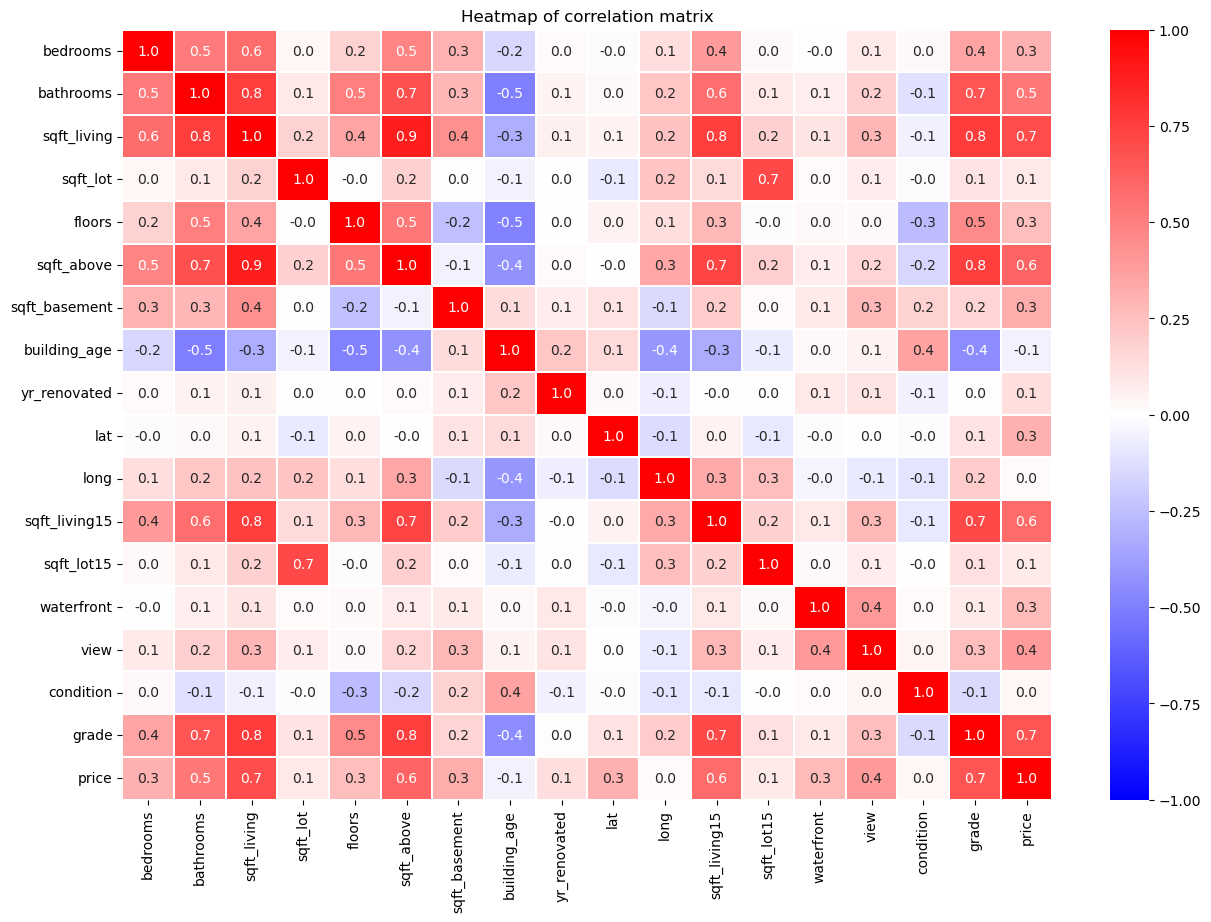

In [6]:
def plot_corr_heatmap(data, columns, title=None):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(title)
    corr_matrix = data[columns].corr()
    sns.heatmap(corr_matrix, annot=True, 
                fmt=".1f", linewidth=.25, 
                vmin=-1, vmax=1,
                ax=ax, cmap="bwr"
               )
    plt.show()
    
plot_corr_heatmap(data, features_columns + [target_column], "Heatmap of correlation matrix")

In [7]:
import numpy as np
import pandas as pd
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        self.thresh = thresh
        
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [16]:
Mult_Coll = ReduceVIF()
updated_columns = Mult_Coll.fit_transform(data[features_columns]).columns

ReduceVIF fit
ReduceVIF transform


/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping sqft_living with vif=inf
Dropping lat with vif=120515.3424153273
Dropping grade with vif=140.85085934614534
Dropping long with vif=68.28725529547044
Dropping bathrooms with vif=27.544766899920884
Dropping sqft_living15 with vif=21.68255799503856
Dropping bedrooms with vif=19.62459376942609
Dropping condition with vif=16.31162504928614


In [15]:
Mult_Coll = ReduceVIF()
updated_columns = Mult_Coll.fit_transform(data[features_columns].loc[mask.index]).columns

ReduceVIF fit
ReduceVIF transform


/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping sqft_living with vif=inf
Dropping lat with vif=110687.42951775074
Dropping long with vif=168.63220311876034
Dropping grade with vif=71.2919754639475
Dropping bathrooms with vif=28.43059768340003
Dropping sqft_living15 with vif=26.128297641879414
Dropping bedrooms with vif=23.232684908838593
Dropping condition with vif=17.659780501380926


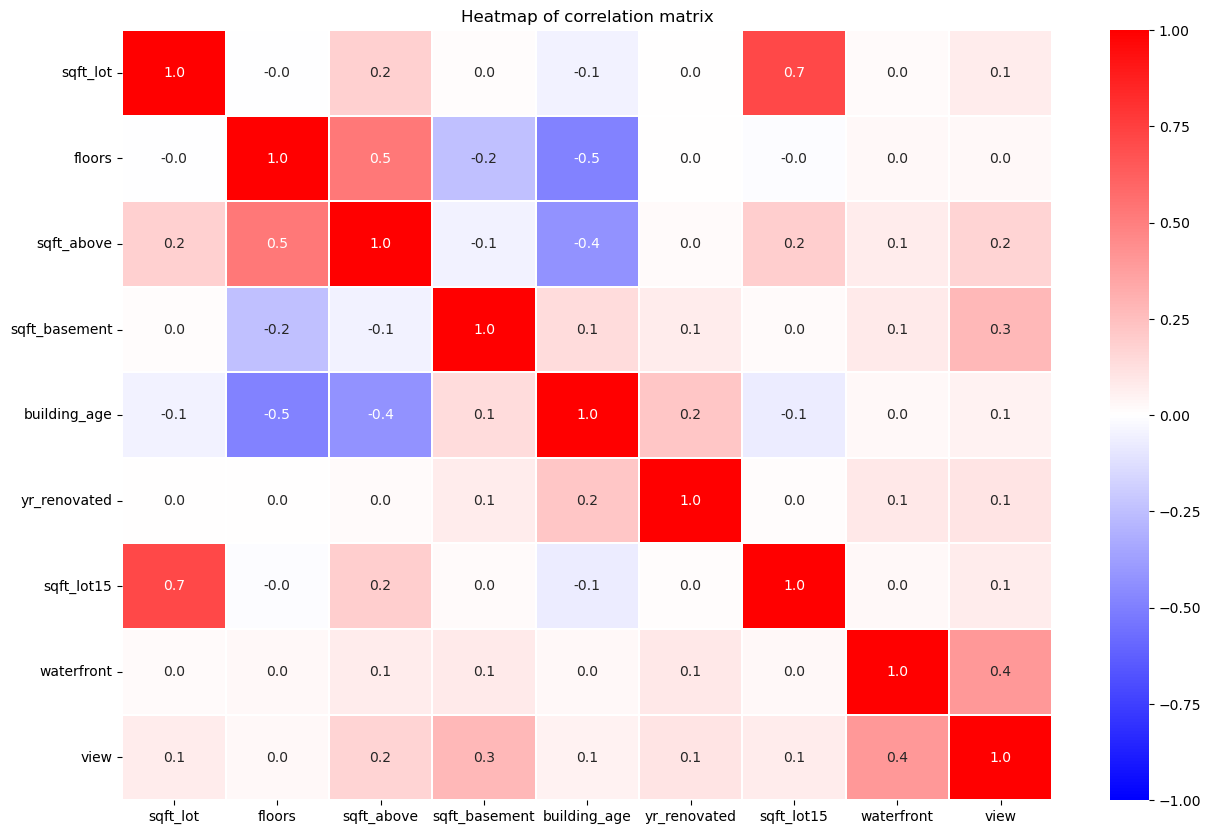

In [36]:
plot_corr_heatmap(data, updated_columns, "Heatmap of correlation matrix")

In [8]:
import statsmodels.api as sm

def linear_reg(data, features):
    X, y = sm.add_constant(data[features]), data[target_column]
    model = sm.OLS(y, X)
    result = model.fit()
    return result

def get_std_residuals(residuals, deegree_of_freedom):
    ss_residual = residuals.map(lambda x: x**2).sum()
    return residuals/np.sqrt(ss_residual/deegree_of_freedom)

In [9]:
def remove_emissions(data, features):
    result = linear_reg(data, features)
    std_residual = get_std_residuals(result.resid, len(result.resid) - 1)
    mask = np.abs(std_residual) < 2
    print((~mask).sum())
    if (~mask).sum() > 0:
        return remove_emissions(data[mask], features)
    else:
        return result, mask

In [40]:
linear_reg(data, updated_columns).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     3791.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:09:03   Log-Likelihood:            -2.9813e+05
No. Observations:               21613   AIC:                         5.963e+05
Df Residuals:                   21604   BIC:                         5.963e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.491e+05   8032.509    -31.010      0.000   -2.65e+05   -2.33e+05
floors         5.988e+04   3898.529     15.359      0.000    5.22e+04    6.75e+04
sqft_above      281.3789      2.456    114.549      0.000     276.564     286.194
sqft_basement   249.8456      3.939     63.425      0.000     242.124     257.567
building_age   2495.8303     67.521     36.964      0.000    2363.485    2628.176
yr_renovated     16.4717      4.194      3.928      0.000       8.252      24.691
sqft_lot15       -0.6090      0.061    -10.017      0.000      -0.728      -0.490
waterfront     5.574e+05   2.04e+04     27.348      0.000    5.17e+05    5.97e+05
view           6.843e+04   2435.546     28.097      0.000    6.37e+04    7.32e+04
==============================================================================
Omnibus:                    13346.519   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           505686.832
Skew:                           2.395   Prob(JB):                         0.00
Kurtosis:                      26.207   Cond. No.                     3.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
linear_reg(data, features_columns).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     3082.
Date:                Fri, 14 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:40:20   Log-Likelihood:            -2.9476e+05
No. Observations:               21613   AIC:                         5.895e+05
Df Residuals:                   21596   BIC:                         5.897e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.181e+07   1.53e+06    -27.255      0.000   -4.48e+07   -3.88e+07
bedrooms      -3.415e+04   1903.178    -17.945      0.000   -3.79e+04   -3.04e+04
bathrooms      4.216e+04   3276.490     12.868      0.000    3.57e+04    4.86e+04
sqft_living     108.7222      2.284     47.606      0.000     104.246     113.199
sqft_lot          0.1274      0.048      2.640      0.008       0.033       0.222
floors          760.6881   3605.813      0.211      0.833   -6306.972    7828.348
sqft_above       70.7916      2.270     31.191      0.000      66.343      75.240
sqft_basement    37.9329      2.664     14.241      0.000      32.712      43.154
building_age   2456.2763     72.580     33.842      0.000    2314.014    2598.539
yr_renovated     21.5324      3.680      5.850      0.000      14.318      28.746
lat            5.611e+05   1.05e+04     53.197      0.000     5.4e+05    5.82e+05
long           -1.17e+05    1.2e+04     -9.755      0.000   -1.41e+05   -9.35e+04
sqft_living15    27.4312      3.457      7.935      0.000      20.655      34.207
sqft_lot15       -0.3933      0.074     -5.330      0.000      -0.538      -0.249
waterfront     5.878e+05   1.75e+04     33.625      0.000    5.54e+05    6.22e+05
view           4.943e+04   2146.437     23.028      0.000    4.52e+04    5.36e+04
condition      3.103e+04   2353.444     13.186      0.000    2.64e+04    3.56e+04
grade          9.722e+04   2166.897     44.866      0.000     9.3e+04    1.01e+05
==============================================================================
Omnibus:                    18537.369   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1882235.907
Skew:                           3.617   Prob(JB):                         0.00
Kurtosis:                      48.142   Cond. No.                     2.39e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.69e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
result, mask = remove_emissions(data, updated_columns)
result.summary()

847
1003
714
482
328
211
151
86
61
39
23
18
19
17
11
9
2
2
1
0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     4202.
Date:                Mon, 17 Apr 2023   Prob (F-statistic):               0.00
Time:                        08:18:35   Log-Likelihood:            -2.2911e+05
No. Observations:               17589   AIC:                         4.582e+05
Df Residuals:                   17579   BIC:                         4.583e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.354e+05   4417.340    -30.647      0.000   -1.44e+05   -1.27e+05
sqft_lot          0.1676      0.032      5.218      0.000       0.105       0.231
floors         9.116e+04   2042.874     44.622      0.000    8.72e+04    9.52e+04
sqft_above      182.8690      1.452    125.967      0.000     180.024     185.715
sqft_basement   186.3777      2.242     83.113      0.000     181.982     190.773
building_age   2184.2007     36.635     59.620      0.000    2112.392    2256.010
yr_renovated     -4.6257      2.434     -1.901      0.057      -9.396       0.145
sqft_lot15       -0.2301      0.046     -5.023      0.000      -0.320      -0.140
waterfront     6.976e+05   1.91e+04     36.576      0.000     6.6e+05    7.35e+05
view            4.73e+04   1473.480     32.100      0.000    4.44e+04    5.02e+04
==============================================================================
Omnibus:                     3066.513   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              660.515
Skew:                           0.028   Prob(JB):                    3.72e-144
Kurtosis:                       2.052   Cond. No.                     1.08e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
result = linear_reg(data.loc[mask.index], list(updated_columns) + ["grade"])

## Тест Уайта

In [30]:
from statsmodels.stats.diagnostic import het_white, spec_white

white_test = spec_white(result.resid,  result.model.exog)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

print(dict(zip(labels, white_test)))

{'Test Statistic': 544.5439792093782, 'Test Statistic p-value': 2.3774667750896387e-77, 'F-Statistic': 64}


p-значения < 0,05 => имеется гетероскедастичность 